# Regridding curvilinear data using python
__Jonah Shaw, 2021/02/09__

I am going to try and write a flexible python function that functions like np.interp_like, but works for curvilinear grids and handles longitude mismatches.

### Add paths to run locally or off Cheyenne or Casper 

In [25]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, xe,
    Path
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

### Check running location and adjust working directory appropriately.

In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)
    
elif 'casper' in host: # Check if running on NIRD through the Jupyter Hub
    print('Running through CISL Casper')
    obs_dir = '/glade/u/home/jonahshaw/w/obs/'
#     model_dir = '/glade/p/cesm/pcwg/jenkay/COSP/'
    os.chdir(obs_dir)
    
elif 'r6i6' in host: # Check if running on NIRD through the Jupyter Hub
    print('Running through CISL Cheyenne')
    obs_dir = '/glade/u/home/jonahshaw/w/obs/'
#     model_dir = '/glade/p/cesm/pcwg/jenkay/COSP/'
    os.chdir(obs_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = '/glade/u/home/jonahshaw/figures/'
obs_dir = '/glade/u/home/jonahshaw/w/obs/'
model_dir = '/glade/p/cesm/pcwg/jenkay/COSP/'
# case_dir = '/glade/p/cesm/pcwg/jenkay/COSP/cesm21/' 

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(model_dir) #and os.path.exists(conv_dir)
print('Can access all directory paths:', access_paths)

Running through CISL Casper
Can access all directory paths: True


## Create dask client for parallel operations

I basically tried different commands until this worked, and I don't have a good understanding of how to change things. Also, I can't seem to shut it down correctly....

In [6]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=8,
                     processes=16, memory="50GB",
                     project='UCUC0007',
                     queue='dav',
                     resource_spec='select=1:ncpus=4:mem=50G',
                     walltime='00:15:00')

cluster.scale(18)

from dask.distributed import Client
client = Client(cluster)
client


Client Scheduler: tcp://10.12.205.13:39782 Dashboard: http://10.12.205.13:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Step by step interpolation
Working with interpolating GOCCP data to a 1-deg CESM grid.

### Starting with a 2D field.

Move to GOCCP directory.

In [3]:
%cd /glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/
%ls

/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata
1.25x0.9_interpolation/  goccp_original/
1.25x0.9_python_interp/  remapweights.nc


Open raw GOCCP data and 1x1 CESM grid (all variables monthly output).

In [4]:
raw_goccp = xr.open_dataset('goccp_original/2006/MapLowMidHigh_Phase330m_200606_avg_CFMIP2_sat_3.1.2.nc')
cesm2_09res = xr.open_dataset('%s/cesm21/cesm2p1_B1850_COSP2_PCWG/atm/hist/%s' % (model_dir,'cesm2p1_B1850_COSP2_PCWG.cam.h0.0003-05.nc'))
# old_interp = xr.open_dataset('1.25x0.9_interpolation/2006/MapLowMidHigh_Phase330m_200606_avg_CFMIP2_sat_3.1.2.nc')

In [12]:
outtest

<xarray.Dataset>
Dimensions:          (cat1: 6, lat: 192, lon: 288, time: 1, toplvl: 3)
Coordinates:
  * toplvl           (toplvl) float32 0.0 0.0 0.0
  * time             (time) datetime64[ns] 2006-06-21T18:00:00
  * lon              (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat              (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
Dimensions without coordinates: cat1
Data variables:
    cllcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cllcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cllcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cllcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    category         (cat1) |S25 ...
Attributes:
    regrid_method:  bilinear

In [6]:
def interp_like2D(ds_in, target=None, method='bilinear',verbose=False,regridder=None):
    '''
    Wrapper function for xESMF regridder object.
    Takes an xarray dataarray or dataset and interpolates to
    the lat-lon grid of the target for all variables with lat-lon vars.
    Returns interpolated array and regridder object for repeated use.
    Either target or regridder have to be supplied in the function call.
    '''
    
    # Get correct horizontal coordinate names (differs between models, obs)
    ds_lat,ds_lon = get_horiz_coords(ds_in, verbose=verbose)
    
    # Remove non-horizontal variables from the input dataset (returned as drops):
    ds_clean,drops = get_horiz_vars(ds_in, verbose=verbose)
    
    # Rotate and wrap longitude appropriately:
    ds_clean.coords[ds_lon] = ds_clean.coords[ds_lon] % 360
    ds_clean = ds_clean.sortby(ds_clean.coords[ds_lon]) # Does this work?
    
    # Create target grid and regridder if it wasn't been passed
    if not regridder:
        targ_lat,tar_lon = get_horiz_coords(target, verbose=verbose)
    
        # Create target lat-lon grid from target input
        targ_out = xr.Dataset({targ_lat: ([targ_lat], target[targ_lat].values),
                         tar_lon: ([tar_lon], target[tar_lon].values),}
                             )
        regridder = xe.Regridder(ds_clean, targ_out, method)
    
    # Regrid!
    try:
        ds_out = regridder(ds_clean)
    except:
        print('Regrid failed. Input was: ', ds_clean)
        return None
    
    # Add lat/lon free dropped variables back in (what about just lat or lon?)
    for i in drops:
        ds_out[i] = drops[i]
#         if not any(get_horiz_coords(i, verbose=verbose)):
#             print("I should add %s back in." % i)

    return ds_out,regridder
    

In [7]:
def get_horiz_coords(ds,verbose=False):
    '''
    Helper function for interpolation. Distinguishes between
    netCDF files using lat-lon and latitude-longitude conventions.
    '''
    
    if 'lat' in ds.coords:
        _lat = 'lat'
    elif 'latitude' in ds.coords:
        _lat = 'latitude'
    else:
        if verbose: print('Recognizable latitude coordinate not found.')
        _lat = False
    
    if 'lon' in ds.coords:
        _lon = 'lon'
    elif 'longitude' in ds.coords:
        _lon = 'longitude'
    else:
        if verbose: print('Recognizable longitude coordinate not found.')
        _lon = False
    
    return _lat,_lon
    

In [8]:
def get_horiz_vars(ds_in,verbose=False):
    '''
    Helper function for interp_like2D. 
    Removes non-lat/lon variables that would cause the interpolation to fail.
    Transposes variables so that any remaining coordinates come before lat/lon?
    ^See documentation of xESMF for explanation.
    '''
    ds = ds_in.copy()
    
    coords = ds.coords # Data coords to check against
    drops = {}
    for i in ds.variables:
        if i not in coords: # Cross-check against coordinates
            _horiz_coords = get_horiz_coords(ds[i])
            if False in _horiz_coords:
                if verbose: print('Will not interpolate "%s", horizontal coordinates not found.' % i)
                drops[i] = raw_goccp[i] # Save variable so it isn't lost to append later.
                ds = ds.drop(i)
            else: # This is where I would transpose if necessary, but that is not yet an issue.
                pass
    #             test_ds[i] = test_ds[i].transpose(...,_horiz_coords[0],_horiz_coords[1])

        else:
            if verbose: print('Excluded "%s" because found in coords: ' % i)
            
    return ds, drops

In [9]:
def interp_files(in_paths,out_paths,target,use_dask=False):
    '''
    This is a wrapper for interp_like2D to process multiple files.
    I am trying to build in parallizability, but dask isn't working for me yet.
    '''
    # Need to figure out how to use dask here.
#     https://docs.dask.org/en/latest/delayed-best-practices.html
    
    # Process the first file to create a regridder.
    target_ds = xr.open_dataset(target)
    regridder = interp_and_save(in_paths[0],out_paths[0],target=target_ds)
    
    results = []
    for _in,_out in zip(in_paths[1:],out_paths[1:]):
        if use_dask:
            _task = dask.delayed(interp_and_save)(_in,_out,regridder=regridder)
            results.append(_task)
        else:
            interp_and_save(_in,_out,regridder=regridder)
            
    if use_dask: dash.compute(*results)

In [14]:
def interp_and_save(in_path,out_path, **kwargs):
    '''
    To be called by interp_files().
    Organized this way to work well with Dask.
    '''
    # kwargs will be the target or regridder and potentially the method as well
    
    ds = xr.open_dataset(in_path)
    
    ds_out,regrdr = interp_like2D(ds, **kwargs) 
    
    ds_out.to_netcdf(out_path)
    
    return regrdr #?

## Test the interpolation!

In [21]:
%ls 1.25x0.9_python_interp/

In [19]:
%rm -r 1.25x0.9_python_interp/*

In [22]:
%ls

1.25x0.9_interpolation/  goccp_original/
1.25x0.9_python_interp/  remapweights.nc


In [87]:
path = os.getcwd()
path

'/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata'

## Test on a file subset

Select files, create outfile paths and make sure that those paths exist.

In [23]:
%ls 1.25x0.9_interpolation

2006/  2007/  2008/  2009/  2010/  2011/  2012/  2013/  2014/  2015/


In [37]:
interp_dir = '/goccp_original/2015/'
path = os.getcwd()

prefix = path + interp_dir
in_files = os.listdir(prefix)

in_files_full = [prefix + i for i in in_files]
out_files_full = [i.replace('goccp_original','1.25x0.9_python_interp') for i in in_files_full]

# Make sure the directory structure exists before writing files in interp_like2D
for i in out_files_full:
    parent = Path(i).parent
    Path(parent).mkdir(parents=True, exist_ok=True)

# Specify file to interpolate to.
target_file = '%s/cesm21/cesm2p1_B1850_COSP2_PCWG/atm/hist/%s' % (model_dir,'cesm2p1_B1850_COSP2_PCWG.cam.h0.0003-05.nc')

interp_files(in_files_full,out_files_full,target_file)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/glade/work/jonahshaw/minico

In [129]:
%ls 1.25x0.9_python_interp/2006/

MapLowMidHigh330m_200606_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh330m_200607_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh330m_200608_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh330m_200609_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh330m_200610_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh330m_200611_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh330m_200612_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200606_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200607_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200608_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200609_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200610_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200611_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200612_avg_CFMIP2_sat_3.1.2.nc


In [88]:
prefix = path + '/goccp_original/2006/'
in_files_full = [prefix + i for i in in_files]
in_files_full

['/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/goccp_original/2006/MapLowMidHigh330m_200607_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/goccp_original/2006/MapLowMidHigh330m_200608_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/goccp_original/2006/MapLowMidHigh_Phase330m_200611_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/goccp_original/2006/MapLowMidHigh330m_200606_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/goccp_original/2006/MapLowMidHigh_Phase330m_200609_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/goccp_original/2006/MapLowMidHigh_Phase330m_200612_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/goccp_original/2006/MapLowMidHigh_Phase330m_200606_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/goccp_original/2006/MapLowMidHigh_Phase330m_200607_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/w

In [93]:
out_files_full = [i.replace('goccp_original','1.25x0.9_python_interp') for i in in_files_full]
out_files_full

['/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/1.25x0.9_python_interp/2006/MapLowMidHigh330m_200607_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/1.25x0.9_python_interp/2006/MapLowMidHigh330m_200608_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/1.25x0.9_python_interp/2006/MapLowMidHigh_Phase330m_200611_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/1.25x0.9_python_interp/2006/MapLowMidHigh330m_200606_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/1.25x0.9_python_interp/2006/MapLowMidHigh_Phase330m_200609_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/1.25x0.9_python_interp/2006/MapLowMidHigh_Phase330m_200612_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/1.25x0.9_python_interp/2006/MapLowMidHigh_Phase330m_200606_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/1.25x0.9_python_interp/2006/Map

In [92]:
for i in in_files_full:
    if not os.path.exists(i):
        print('%s does not exists' % i)

In [107]:
# Make sure the directory structure exists before writing files in interp_like2D
for i in out_files_full:
    parent = pathlib.Path(i).parent
    pathlib.Path(parent).mkdir(parents=True, exist_ok=True)

In [98]:
import pathlib

In [101]:
pathlib.Path(in_files_full[0])

PosixPath('/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/goccp_original/2006/MapLowMidHigh330m_200607_avg_CFMIP2_sat_3.1.2.nc')

In [100]:
pathlib.Path(in_files_full[0]).parent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


PosixPath('/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/goccp_original/2006')

In [ ]:
existGDBPath = pathlib.Path(r'T:\Data\DBDesign\DBDesign_93_v141b.mdb')
wkspFldr = existGDBPath.parent
print wkspFldr

In [ ]:
Path("/my/directory").mkdir(parents=True, exist_ok=True)

In [76]:
'1.25x0.9_python_interp/' + in_files

TypeError: can only concatenate str (not "list") to str

In [74]:
tom

## To do later in dask (while testing efficiency?)

In [ ]:
# Break up into many tasks

@dask.delayed
def load(filename):
    ...

@dask.delayed
def process(filename):
    ...

@dask.delayed
def save(filename):
    ...


def f(filenames):
    results = []
    for filename in filenames:
        data = load(filename)
        data = process(data)
        result = save(data)

    return results

dask.compute(f(filenames))

In [29]:
interpd,regrid = interp_like2D(raw_goccp,cesm2_09res,verbose=False)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [34]:
interpd2,regrid2 = interp_like2D(raw_goccp,None,verbose=False,regridder=regrid)

In [59]:
oop = [0,1,2,3,4,5]

In [60]:
oop[1:]

[1, 2, 3, 4, 5]

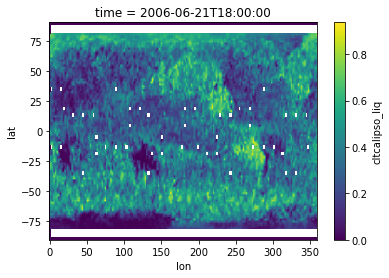

In [39]:
interpd2['cltcalipso_liq'].plot()

In [45]:
testt = raw_goccp['cltcalipso_liq'].where(raw_goccp['cltcalipso_liq'] is np.nan)

In [37]:
regrid

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_90x180_192x288.nc 
Reuse pre-computed weights? False 
Input grid shape:           (90, 180) 
Output grid shape:          (192, 288) 
Periodic in longitude?      False

In [38]:
regrid2

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_90x180_192x288.nc 
Reuse pre-computed weights? False 
Input grid shape:           (90, 180) 
Output grid shape:          (192, 288) 
Periodic in longitude?      False

In [30]:
interpd

<xarray.Dataset>
Dimensions:          (cat1: 6, lat: 192, lon: 288, time: 1, toplvl: 3)
Coordinates:
  * toplvl           (toplvl) float32 0.0 0.0 0.0
  * time             (time) datetime64[ns] 2006-06-21T18:00:00
  * lon              (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat              (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
Dimensions without coordinates: cat1
Data variables:
    cllcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cllcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cllcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cllcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    category         (cat1) |S25 b'UNDEFINED                ' ... b'Unphysica...
Attributes:
    regrid_method:  bilinear

__Look at GOCCP data__

In [54]:
raw_goccp

<xarray.Dataset>
Dimensions:          (cat1: 6, latitude: 90, longitude: 180, time: 1, toplvl: 3)
Coordinates:
  * longitude        (longitude) float32 -179.0 -177.0 -175.0 ... 177.0 179.0
  * latitude         (latitude) float32 -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
  * toplvl           (toplvl) float32 0.0 0.0 0.0
  * time             (time) datetime64[ns] 2006-06-21T18:00:00
Dimensions without coordinates: cat1
Data variables:
    category         (cat1) |S25 b'UNDEFINED                ' ... b'Unphysica...
    cllcalipso_liq   (time, latitude, longitude) float32 ...
    clmcalipso_liq   (time, latitude, longitude) float32 ...
    clhcalipso_liq   (time, latitude, longitude) float32 ...
    cltcalipso_liq   (time, latitude, longitude) float32 ...
    cllcalipso_ice   (time, latitude, longitude) float32 ...
    clmcalipso_ice   (time, latitude, longitude) float32 ...
    clhcalipso_ice   (time, latitude, longitude) float32 ...
    cltcalipso_ice   (time, latitude, longitude) float32 ...
    cllcalipso_un    (time, cat1, latitude, longitude) float32 ...
    clmcalipso_un    (time, cat1, latitude, longitude) float32 ...
    clhcalipso_un    (time, cat1, latitude, longitude) float32 ...
    cltcalipso_un    (time, cat1, latitude, longitude) float32 ...
    cllcalipso_RPIC  (time, latitude, longitude) float32 ...
    clmcalipso_RPIC  (time, latitude, longitude) float32 ...
    clhcalipso_RPIC  (time, latitude, longitude) float32 ...
    cltcalipso_RPIC  (time, latitude, longitude) float32 ...
Attributes:
    Description:               GOCCP_Map_Low_Mid_High_Phase_file
    Date:                      
    Version:                   Prog_version
    Author:                    Gregory CESANA, Helene CHEPFER, LMD/IPSL
    Scientific_contact:        helene.chepfer@lmd.polytechnique.fr
    Technical_support:         gregory.cesana@lmd.polytechnique.fr
    Creationdate:              20180413
    Website:                   http://climserv.ipsl.polytechnique.fr/cfmip-ob...
    References:                Chepfer et al, 2010, The GCM Oriented CALIPSO ...
    history:                   Tue Apr 24 11:20:09 2018: ncra -O /bdd/CFMIP/C...
    NCO:                       "4.5.2"
    nco_openmp_thread_number:  1

Trying dropping the 'category' variable that doesn't have lat/lon coordinates attached.

In [11]:
raw_goccp = raw_goccp.drop('category')

**Load and plot GOCCP data**

In [12]:
dr = raw_goccp['cltcalipso_liq']

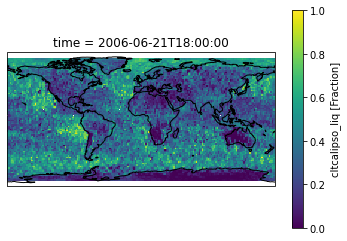

In [13]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr.isel(time=0).plot.pcolormesh(ax=ax); #, vmin=230, vmax=300);
ax.coastlines();

Check input grid resolution.

The coordinates are named differently, so the function should also be able to handle this, since it will produce an error (see below).

In [14]:
try:
    raw_goccp['lat'].values, raw_goccp['lon'].values

except:
    print('Did not work.')

Did not work.


In [15]:
raw_goccp['latitude'].values, raw_goccp['longitude'].values

(array([-89., -87., -85., -83., -81., -79., -77., -75., -73., -71., -69.,
        -67., -65., -63., -61., -59., -57., -55., -53., -51., -49., -47.,
        -45., -43., -41., -39., -37., -35., -33., -31., -29., -27., -25.,
        -23., -21., -19., -17., -15., -13., -11.,  -9.,  -7.,  -5.,  -3.,
         -1.,   1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,
         21.,  23.,  25.,  27.,  29.,  31.,  33.,  35.,  37.,  39.,  41.,
         43.,  45.,  47.,  49.,  51.,  53.,  55.,  57.,  59.,  61.,  63.,
         65.,  67.,  69.,  71.,  73.,  75.,  77.,  79.,  81.,  83.,  85.,
         87.,  89.], dtype=float32),
 array([-179., -177., -175., -173., -171., -169., -167., -165., -163.,
        -161., -159., -157., -155., -153., -151., -149., -147., -145.,
        -143., -141., -139., -137., -135., -133., -131., -129., -127.,
        -125., -123., -121., -119., -117., -115., -113., -111., -109.,
        -107., -105., -103., -101.,  -99.,  -97.,  -95.,  -93.,  -91.,
         -89.,  

Check output grid resolution.

The longitude range is 0-360 rather than -180-180, so we will want to fix this before interpolation.

In [16]:
cesm2_09res['lat'].values, cesm2_09res['lon'].values

(array([-90.        , -89.05759162, -88.11518325, -87.17277487,
        -86.23036649, -85.28795812, -84.34554974, -83.40314136,
        -82.46073298, -81.51832461, -80.57591623, -79.63350785,
        -78.69109948, -77.7486911 , -76.80628272, -75.86387435,
        -74.92146597, -73.97905759, -73.03664921, -72.09424084,
        -71.15183246, -70.20942408, -69.26701571, -68.32460733,
        -67.38219895, -66.43979058, -65.4973822 , -64.55497382,
        -63.61256545, -62.67015707, -61.72774869, -60.78534031,
        -59.84293194, -58.90052356, -57.95811518, -57.01570681,
        -56.07329843, -55.13089005, -54.18848168, -53.2460733 ,
        -52.30366492, -51.36125654, -50.41884817, -49.47643979,
        -48.53403141, -47.59162304, -46.64921466, -45.70680628,
        -44.76439791, -43.82198953, -42.87958115, -41.93717277,
        -40.9947644 , -40.05235602, -39.10994764, -38.16753927,
        -37.22513089, -36.28272251, -35.34031414, -34.39790576,
        -33.45549738, -32.51308901, -31.

### Create the target dataset (2D)

I will copy in the latitude and longitude from the target file.

In [17]:
ds_out = xr.Dataset({'lat': (['lat'], cesm2_09res['lat'].values),
                     'lon': (['lon'], cesm2_09res['lon'].values),
                    }
                   )
ds_out

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    *empty*

In [18]:
raw_goccp_mod = raw_goccp.copy()

Rotate and wrap longitude appropriately.

In [105]:
raw_goccp_mod.coords['longitude'] = raw_goccp_mod.coords['longitude'] % 360
# raw_goccp_mod.coords['longitude'] = (raw_goccp_mod.coords['longitude'] + 180) % 360
# raw_goccp_mod = raw_goccp_mod.sortby(raw_goccp_mod.coords['longitude'])
raw_goccp_mod = raw_goccp_mod.sortby(raw_goccp_mod.longitude)

This just recalculates:

In [44]:
# input_rotat = raw_goccp.assign_coords({"longitude": (((raw_goccp.longitude + 180) % 360))})
# input_rotat = input_rotat.sortby(input_rotat.longitude)

This recalculates and creates the 'lon' coordinate. A general call will have 'lon' or 'longitude' as an argument:

In [13]:
# input_rotat2 = raw_goccp.assign_coords({"lon": (((raw_goccp.longitude + 180) % 360))})

In [20]:
raw_goccp_mod.longitude.values, cesm2_09res.lon.values

(array([  1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,
         23.,  25.,  27.,  29.,  31.,  33.,  35.,  37.,  39.,  41.,  43.,
         45.,  47.,  49.,  51.,  53.,  55.,  57.,  59.,  61.,  63.,  65.,
         67.,  69.,  71.,  73.,  75.,  77.,  79.,  81.,  83.,  85.,  87.,
         89.,  91.,  93.,  95.,  97.,  99., 101., 103., 105., 107., 109.,
        111., 113., 115., 117., 119., 121., 123., 125., 127., 129., 131.,
        133., 135., 137., 139., 141., 143., 145., 147., 149., 151., 153.,
        155., 157., 159., 161., 163., 165., 167., 169., 171., 173., 175.,
        177., 179., 181., 183., 185., 187., 189., 191., 193., 195., 197.,
        199., 201., 203., 205., 207., 209., 211., 213., 215., 217., 219.,
        221., 223., 225., 227., 229., 231., 233., 235., 237., 239., 241.,
        243., 245., 247., 249., 251., 253., 255., 257., 259., 261., 263.,
        265., 267., 269., 271., 273., 275., 277., 279., 281., 283., 285.,
        287., 289., 291., 293., 295., 

In [15]:
# raw_goccp.longitude.values, input_rotat.longitude.values, cesm2_09res.lon.values

### Perform regridding
Make a regridder by xe.Regridder(grid_in, grid_out, method). The grids are just an xarray DataSet containing lat and lon values. See xESMF documentation for discussion of regridding methods.

It looks like you feed this object the input and output grids along with a regridding method and it creates weights and can then be used to regrid at will.

It looks like the regridder doesn't need me to relabel the longitude axis, great!

In [27]:
regridder3 = xe.Regridder(raw_goccp_mod, ds_out, 'bilinear')
regridder3  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_90x180_192x288.nc 
Reuse pre-computed weights? False 
Input grid shape:           (90, 180) 
Output grid shape:          (192, 288) 
Periodic in longitude?      False

In [31]:
regridder4 = xe.Regridder(dr, ds_out, 'bilinear')
regridder4  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_90x180_192x288.nc 
Reuse pre-computed weights? False 
Input grid shape:           (90, 180) 
Output grid shape:          (192, 288) 
Periodic in longitude?      False

In [21]:
regridder5 = xe.Regridder(raw_goccp, ds_out, 'bilinear')
regridder5  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_90x180_192x288.nc 
Reuse pre-computed weights? False 
Input grid shape:           (90, 180) 
Output grid shape:          (192, 288) 
Periodic in longitude?      False

Regridding the DataArray:  

In [28]:
dr_out3 = regridder3(dr)
dr_out3

<xarray.DataArray 'cltcalipso_liq' (time: 1, lat: 192, lon: 288)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., nan, nan, ..., nan, nan, nan],
        ...,
        [ 0., nan, nan, ..., nan, nan, nan],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])
Coordinates:
  * time     (time) datetime64[ns] 2006-06-21T18:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Attributes:
    regrid_method:  bilinear

In [32]:
dr_out4 = regridder4(dr)
dr_out4

<xarray.DataArray 'cltcalipso_liq' (time: 1, lat: 192, lon: 288)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])
Coordinates:
  * time     (time) datetime64[ns] 2006-06-21T18:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Attributes:
    regrid_method:  bilinear

In [22]:
dr_out5 = regridder5(raw_goccp)
dr_out5

<xarray.Dataset>
Dimensions:          (cat1: 6, lat: 192, lon: 288, time: 1, toplvl: 3)
Coordinates:
  * toplvl           (toplvl) float32 0.0 0.0 0.0
  * time             (time) datetime64[ns] 2006-06-21T18:00:00
  * lon              (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat              (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
Dimensions without coordinates: cat1
Data variables:
    cllcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cllcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cllcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cllcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [23]:
dr_out5

<xarray.Dataset>
Dimensions:          (cat1: 6, lat: 192, lon: 288, time: 1, toplvl: 3)
Coordinates:
  * toplvl           (toplvl) float32 0.0 0.0 0.0
  * time             (time) datetime64[ns] 2006-06-21T18:00:00
  * lon              (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat              (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
Dimensions without coordinates: cat1
Data variables:
    cllcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cllcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cllcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cllcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

Yay! No vertical line here!

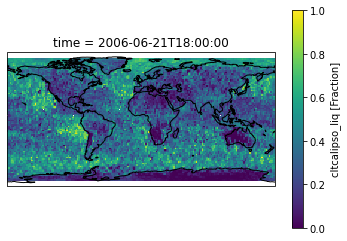

In [21]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr.isel(time=0).plot.pcolormesh(ax=ax); #, vmin=230, vmax=300);
ax.coastlines();

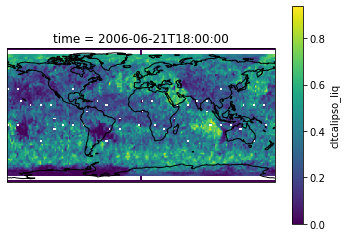

In [29]:
ax_out = plt.axes(projection=ccrs.PlateCarree())
dr_out3.isel(time=0).plot.pcolormesh(ax=ax_out); #, vmin=230, vmax=300);
ax_out.coastlines();

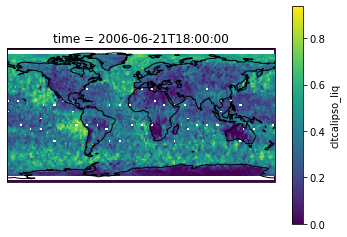

In [33]:
ax4 = plt.axes(projection=ccrs.PlateCarree())
dr_out4.isel(time=0).plot.pcolormesh(ax=ax4); #, vmin=230, vmax=300);
ax4.coastlines();

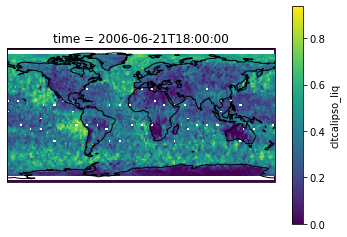

In [24]:
ax5 = plt.axes(projection=ccrs.PlateCarree())
dr_out5['cltcalipso_liq'].isel(time=0).plot.pcolormesh(ax=ax5); #, vmin=230, vmax=300);
ax5.coastlines();

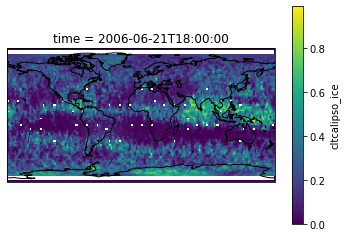

In [25]:
ax5 = plt.axes(projection=ccrs.PlateCarree())
dr_out5['cltcalipso_ice'].isel(time=0).plot.pcolormesh(ax=ax5); #, vmin=230, vmax=300);
ax5.coastlines();

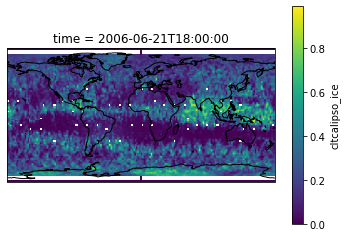

In [138]:
ax5 = plt.axes(projection=ccrs.PlateCarree())
ttest['cltcalipso_ice'].isel(time=0).plot.pcolormesh(ax=ax5); #, vmin=230, vmax=300);
ax5.coastlines();

In [136]:
ttest = interp_like2D(raw_goccp,cesm2_09res)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [170]:
outty = get_horiz_coords(raw_goccp['category'])

In [180]:
outty

(False, False)

In [183]:
[1,2] == False

False

In [182]:
np.all(outty == False)

False

In [178]:
outty3 = 'lon',False

In [179]:
False in outty3

True

In [173]:
outty2 = True,False

In [175]:
np.any('lat')

TypeError: cannot perform reduce with flexible type

In [160]:
not outty2

False

In [171]:
np.all(outty)

False

In [162]:
np.all([[True,True],[True,True]])

True

In [33]:
'longitude' in cesm2_09res.coords

False

In [73]:
for i in raw_goccp.coords:
    print(i)

longitude
latitude
toplvl
time


In [101]:
test_ds = raw_goccp.copy()

coords = test_ds.coords # Data coords to check against
drops = []
for i in test_ds.variables:
    if i not in coords: # Cross-check against coordinates
        _horiz_coords = get_horiz_coords(test_ds[i])
        if None in _horiz_coords:
            print('Will not interpolate "%s", horizontal coordinates not found.' % i)
            drops.append(raw_goccp[i]) # Save variable so it isn't lost. Maybe not necessary if we return a different data object
            test_ds.drop(i)
        else: # This is where I would transpose if necessary, but that might not be an issue.
            pass
#             test_ds[i] = test_ds[i].transpose(...,_horiz_coords[0],_horiz_coords[1])

    else:
        print('Excluded "%s" because found in coords: ' % i)
        
        
#     print(raw_goccp[i].coords.values)

Excluded "longitude" because found in coords: 
Excluded "latitude" because found in coords: 
Recognizable latitude coordinate not found.
Recognizable longitude coordinate not found.
Will not interpolate "category", horizontal coordinates not found.
Excluded "toplvl" because found in coords: 
Excluded "time" because found in coords: 


In [84]:
temp_ds = raw_goccp.copy()['cltcalipso_liq']


In [93]:
temp_ds.transpose(*['latitude','longitude','time'])

<xarray.DataArray 'cltcalipso_liq' (latitude: 90, longitude: 180, time: 1)>
array([[[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
...
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * latitude   (latitude) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * time       (time) datetime64[ns] 2006-06-21T18:00:00
Attributes:
    lon_name:      Total Column Level liq Cloud
    units:         Fraction
    cell_methods:  time: mean

In [96]:
temp_ds.transpose(...,'time')

<xarray.DataArray 'cltcalipso_liq' (latitude: 90, longitude: 180, time: 1)>
array([[[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
...
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * latitude   (latitude) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * time       (time) datetime64[ns] 2006-06-21T18:00:00
Attributes:
    lon_name:      Total Column Level liq Cloud
    units:         Fraction
    cell_methods:  time: mean

In [88]:
['latitude','longitude','time']

['latitude', 'longitude', 'time']

In [89]:
#             _coords_reorg = []
#             for j in test_ds[i].coords:
#                 if j not in _horiz_coords:
#                     _coords_reorg.append(j)
#             _coords_reorg.append(_horiz_coords[0]) # I wish that this could be a single line
#             _coords_reorg.append(_horiz_coords[1])
#             print(_coords_reorg)
#             test_ds[i] = test_ds[i].transpose(*_coords_reorg) # Need to unpack iterable arg
#             print(test_ds[i].coords)

SyntaxError: can't use starred expression here (<ipython-input-89-09994e815e1d>, line 4)

In [23]:
-140 % 360

220

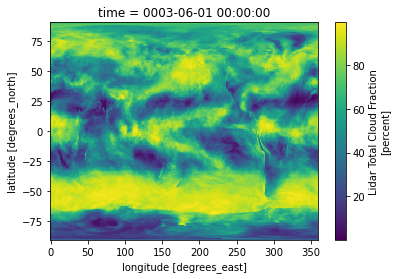

In [30]:
cesm2_09res['CLDTOT_CAL'].plot()

__Important Note:__  

The horizontal shape is now (59, 87), as expected. The regridding operation broadcasts over extra dimensions (time here), so there are still 2920 time frames. lon and lat coordinate values are updated accordingly, and the value of the extra dimension time is kept the same as input.

Important note: Extra dimensions must be on the left, i.e. (time, lev, lat, lon) is correct but (lat, lon, time, lev) would not work. Most data sets should have (lat, lon) on the right (being the fastest changing dimension in the memory). If not, use DataArray.transpose or numpy.transpose to preprocess the data.

Check results on 2D map
The regridding result is consistent with the original data, with a much finer resolution:

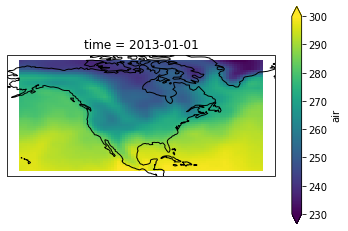

In [10]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr_out.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300);
ax.coastlines();

### Check broadcasting over extra dimensions  

xESMF tracks coordinate values over extra dimensions, since horizontal regridding should not affect them.

In [12]:
dr_out['time']

<xarray.DataArray 'time' (time: 2920)>
array(['2013-01-01T00:00:00.000000000', '2013-01-01T06:00:00.000000000',
       '2013-01-01T12:00:00.000000000', ..., '2014-12-31T06:00:00.000000000',
       '2014-12-31T12:00:00.000000000', '2014-12-31T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    standard_name:  time
    long_name:      Time

In [13]:
# exactly the same as input
xr.testing.assert_identical(dr_out['time'], ds['time'])

### Clean-up  

xESMF saves the regridder to the current directory so you don’t need to re-compute it next time (see Save time by reusing regridder). If you don’t need it anymore, you can just delete it:

This is pretty cool. I need to remember to clean up or I will end up creating a lot of these regridding weight files.

Testing that indeed there is now a weighting file in the current directory:

In [14]:
os.listdir()

['.ipynb_checkpoints', 'CLOUDSAT', 'CALIPSO']

Where is it??

In [35]:
regridder.clean_weight_file()  # regridder.c + TAB would bring-up the command

NameError: name 'regridder' is not defined

Ok, maybe they've updated this since the documentation was written.